# Задача

У заказачика есть архив из ~15000 запросов в техническую поддержку. Каждый запрос и история переписки по нему содержится в отдельном файле. Нет формальных сведений о том, была ли решена проблема, к какой категории она относится и т.д.

Заказчику требуется создать сервис, которому на вход подается новый запрос, а на выходе выдается несколько похожих запросов из архива.

Общий план решения:
1. Читаем архив, анализируем его структуру и содержимое
2. Выделяем из истории переписки собственно запросы в поддержку
3. Подбираем модель для поиска похожих запросов
4. Обучаем модель на неразмеченном датасете
5. Пытаемся уговорить заказчика провести разметку части архива
6. Дообучаем модель с использованием разметки, формируем критерии качества
7. Если получится, используем другие модели, сравниваем по качеству
8. Создаем итоговое приложение и процесс периодического дообучения. Передаем заказчику.

## 1. Читаем архив

Информация предоставлена в виде архива, содержащего:
- файл list.txt, где каждая строка содержит краткую информацию об инциденте и имя файла с историей работы над ним
- соответствущие файлы, на которые ссылается list.txt

Все файлы переданы в кодировке UTF-16. Содержат информацию на английском, русском и латышском языках. В большинстве файлов содержится текст только на одном языке, но могут встречаться и смешанные тексты.

По требованию заказчика нельзя показывать контактные данные людей и организаций, а также конкретную информацию об их ИТ-инфраструктуре (имена серверов и пр.). Поэтому контент просматривался отдельно, а в этом ноутбуке отображаются только действия, предпринятые по итогам анализа.  

Файл list.txt, содержащий список запросов и ссылки на файлы с подробностями, имеет вид CSV из трех полей:
- тема запроса
- идентификатор запроса
- имя файла с подробностями

Каждое поле в list.txt обрамлено кавычками, разделитель запятая. Но есть две проблемы:
- кавычки встречаются и внутри полей
- внутри полей встречаются также переводы строк. 

Из-за этого стандартные ридеры не годятся. Изобретаем регулярное выражение, читаем файл в память и разбираем его построчно.

In [1]:
%run utils.ipynb # Вспомогательные функции

In [ ]:
DATA_SOURCE_DIR = DATA_DIR + "CY/AI3/"

In [3]:
import re
import pandas as pd

RE_RECORD = re.compile(
    r'"(.*?)","(.*?)","(.*?)"(?:\r?\n|$)', # три поля, разделенные кавычками и запятой. Возможно, переходящие на следующую строку
    flags=re.DOTALL)

with open(DATA_SOURCE_DIR + "list.txt", "r", encoding="UTF-16", newline="") as f:
    text = f.read()

rows = []
pos = 0
for m in RE_RECORD.finditer(text):
    if m.start() != pos:
        bad_snippet = text[pos:m.start()]
        preview = bad_snippet[:120].replace("\n", "\\n").replace("\r", "\\r")
        print(f"[!] Пропущенный фрагмент между {pos} и {m.start()}: '{preview}…'")
    rows.append((m.group(1), m.group(2), m.group(3)))
    pos = m.end()

if pos != len(text):
    bad_snippet = text[pos:pos+120].replace("\n", "\\n").replace("\r", "\\r")
    print(f"[!] Неразобранный хвост в конце файла: '{bad_snippet}…'")

df = pd.DataFrame(rows, columns=["subject", "id", "details_filename"])

In [4]:
df.shape

(15926, 3)

Уже после передачи экспортированного архива заказчик попросил игнорировать все файлы, начинающиеся с "CY__"

In [5]:
df["id"].str.startswith("CY__").sum()

699

In [6]:
df = df[~df["id"].str.startswith("CY__")]

Пустых значений ведь нет, как и обещано?

In [7]:
df.isna().sum()

subject             0
id                  0
details_filename    0
dtype: int64

Да, пустых значений нет.

На всякий случай проверим, соответствуют ли имена файлов и id:

In [8]:
df[df["details_filename"] != df["id"] + ".txt"].shape

(0, 3)

Имеем полное соответствие.
 
Далее. По идее, поле id - уникальный идентификатор запроса. А нет ли у нас дубликатов?

In [9]:
df[df.duplicated("id", keep=False)].sort_values("id")

,subject,id,details_filename
3172,paziņojumus par DBMT compact,CY-1021,CY-1021.txt
3177,Обновление клиентов Notes до версии 10,CY-1021,CY-1021.txt
3120,параметры для улучшения быстродействия,CY-1086,CY-1086.txt
3121,COMPRESS_LZ1_CREATE=1,CY-1086,CY-1086.txt
3107,Шаблон E-Mail Control System,CY-1102,CY-1102.txt
...,...,...,...
5155,мониторинг превышения квоты,IBM-9932,IBM-9932.txt
14222,Instant messaging in Basic Mode does not shown,IBM-994,IBM-994.txt
14219,DIIOP Port,IBM-994,IBM-994.txt
5113,Мониторинг серверов Traveler,IBM-9986,IBM-9986.txt


Ай-ай, дубликаты есть, причем у многих их них не совпадает subject. Как объяснил заказчик, такое случиться могло - в исходной базе данных нет жесткого контроля за уникальностью id. Он придумает, как в следующей итерации выполнить экспорт так, чтобы id были уникальными. А пока что придется удалить все эти дубликаты. Причем не оставляя ни одной записи, ибо нет возможности уверенно сказать, какой subject верный. 

In [10]:
df = df[~df.duplicated("id", keep=False)]
df.shape

(13284, 3)

Осталось 13284 записи. Ну, тоже неплохо.

Далее. Добавим в датафрейм содержимое соответствующих файлов:

In [11]:
from tqdm import tqdm
tqdm.pandas()  # это чтобы использовать progress_apply

In [12]:
import os

df = df.copy()
df["details"] = df["details_filename"].progress_apply(
    lambda fn: open(os.path.join(DATA_SOURCE_DIR, fn), "r", encoding="utf-16").read())

100%|██████████| 13284/13284 [00:01<00:00, 9818.83it/s] 


In [13]:
# Удаляем кавычки, обрамляющие текст в каждом из файлов. Почему-то их для нас экспортировали именно так.
df["details"] = df["details"].str.strip('"')

In [14]:
# Добавим длину текстов
df["details_length"] = df["details"].str.len()

## 2. Чистим и структурируем данные

### 2.1 Анализируем длину текстов

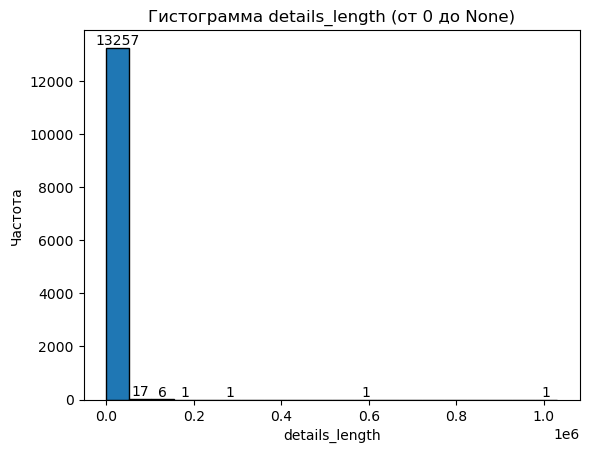

Показано значений: 13284 из 13284 (100.00%)
Ширина одного бина: 51520


In [15]:
plot_hist(df, "details_length", bins=20, show_bin_counts=True)

In [16]:
df_tail = df[["details_filename", "details_length"]][df["details_length"] > 51520].sort_values("details_length", ascending=False)
df_tail

,details_filename,details_length
13978,IBM-1208.txt,1030395
8123,IBM-6538.txt,615551
6211,IBM-8770.txt,273903
6453,IBM-8505.txt,199955
2570,CY-1805.txt,148037
6135,IBM-8847.txt,145315
7880,IBM-6784.txt,144291
4935,IBM-10178.txt,143109
7881,IBM-6782.txt,139871
8320,IBM-6310.txt,111286


Ничего себе разброс! 

Заглянув в некоторые файлы понимаем, что это:
- картинки, вставленные как "Content-Type: image/..."
- тексты, закодированные через base64
- очень длинная кое-где история переписки
- очень длинные исходные запросы (с логами, к примеру)

Ищем записи, содержащие закодированные изображения. Это пока за рамками нашей задачи, будем такие удалять

In [17]:
image_entries = df[df["details"].str.contains("Content-Type: image/", na=False, regex=False)]
image_entries.shape

(3, 5)

Тем более, что их всего 7 штук. Удаляем 

In [18]:
df = df[~df["details"].str.contains("Content-Type: image/", na=False, regex=False)]

А сколько записей содержат текст, закодированный через base64?

In [19]:
base64_entries = df[df["details"].str.contains("Content-Transfer-Encoding: base64", na=False, regex=False)]
base64_entries.shape

(8, 5)

Тоже совсем немного. Можно будет в будущем заморочиться раскодированием, но пока удалим и эти записи

In [20]:
df = df[~df["details"].str.contains("Content-Transfer-Encoding: base64", na=False, regex=False)]

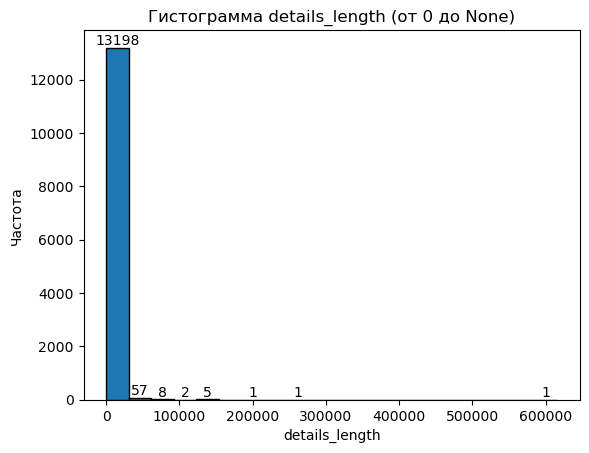

Показано значений: 13273 из 13273 (100.00%)
Ширина одного бина: 30778


In [21]:
plot_hist(df, "details_length", bins=20, show_bin_counts=True)

Есть соблазн удалить "хвост", но это реальные запросы с длинной историей. Оставим как есть.

### 2.2 Удаляем подписи и дисклеймеры

Очевидно, что нужно удалить подписи и дисклеймеры, так как они занимают очень много места, часто повторяются, но не несут смысловой контент. 

С поиском подписей и дисклеймеров все сложно. Я ничего пока умнее не придумал, как выборочно пройтись по датасету вручную и заносить все такие блоки текста как есть в отдельный файл known_blocks_to_remove.txt, а потом их искать буквально и удалять.

Заодно убираем из текста все лишние пробельные символы и приводим его к нижнему регистру.

In [22]:
# Функция, которая удаляет дублирующиеся пробельные символы и приводит текст к нижнему регистру.
# Применяем ее и к удаляемым блокам, и к анализируемому тексту запросов.
def normalize_text(text: str) -> str:
    norm = re.sub(r'\n\s*>+', '\n', text) # удаляем символ цитаты
    norm = " ".join(norm.split()) # все пробельные символы заменяем на один пробел
    norm = re.sub(r"\s+([.,!?;:])", r"\1", norm) # убираем пробел перед знаками пунктуации
    return norm.lower()


In [23]:
print(f"|{normalize_text(" Привет\n>, мир !  ")}|")

|привет, мир!|


In [24]:
# Функция загрузки подлежащих удалению текстовых блоков из файла
SEPARATOR = "=== Это разделитель многострочных записей. Он должен быть именно таким. Копируйте и вставляйте между блоками текста. ===" # ожидаем такой же точно в файле
SEP_RE = re.compile(rf"(?m)^\s*{re.escape(SEPARATOR)}\s*$") 

def load_text_blocks(path):
    with open(path, "r", encoding="utf-8") as f:
        raw = f.read()
    parts = SEP_RE.split(raw)
    blocks = [normalize_text(p) for p in parts if p.strip() != ""]
    return blocks

In [25]:
# Функция удаления текстовых блоков из текста
# Возвращает нормализованный текст, его длину и количество удаленных блоков.
def clean_text(text, block_list):
    norm_text = normalize_text(text)
    removed_count = 0

    for block in block_list:
        count = norm_text.count(block)
        if count > 0:
            norm_text = norm_text.replace(block, "")
            removed_count += count

    return norm_text, len(norm_text), removed_count

Загружаем подлежащие удалению текстовые блоки из файла, находим их в details, результаты помещаем в details_no_signs.

In [26]:
known_blocks_to_remove = load_text_blocks("../data/known_blocks_to_remove.txt")
print(f"Всего текстовых блоков: {len(known_blocks_to_remove)}")
known_blocks_to_remove = list(set(known_blocks_to_remove)) # list->set->list - для удаления дубликатов
print(f"Всего уникальных текстовых блоков: {len(known_blocks_to_remove)}")
known_blocks_to_remove = sorted(known_blocks_to_remove, key=len, reverse=True) # сначала будем удалять самые длинные блоки, т.к. могут встретиться блоки с одним и тем же началом.
df[["details_no_signs", "details_no_signs_length", "removed_blocks_count"]] = df["details"].progress_apply(
    lambda x: pd.Series(clean_text(x, known_blocks_to_remove)))

Всего текстовых блоков: 598
Всего уникальных текстовых блоков: 486


100%|██████████| 13273/13273 [00:06<00:00, 2043.91it/s]


Далее вспомогательный код для поиска подписей. Потенциальные подписи ищутся по номерам телефонов. Смотрим в получившуюся таблицу, открываем файлы по id, находим в них подписи и заносим их как есть в файл known_blocks_to_remove.txt. Работа не производительная, но хорошо хоть, что однажды найденная подпись удаляется сразу из многих запросов. То же самое касается дисклеймеров. Их обнаруживаем попутно с подписями и заносим в тот же файл.


In [27]:
def find_signatures(df):
    """
    Возвращает датасет, показывающий, в каких файлах встречаются номера телефонов.
    """

    def find_international_phones(text: str):
        pattern = re.compile(
            r'\+\d{1,3}[\s\-()]*\d(?:[\d\s\-()]{5,15}\d)',
            re.MULTILINE
        )
        return pattern.findall(text)
        
    df['phones'] = df['details_no_signs'].apply(lambda x: tuple(find_international_phones(str(x))))
    df_exploded = df[['details_filename', 'phones']].explode('phones').dropna(subset=['phones'])
    result = (
        df_exploded.groupby('phones')
        .agg(
            mentions=('details_filename', 'size'),                         # всего упоминаний телефона
            ids=('details_filename', lambda s: sorted(set(s)))             # уникальные id как список
        )
        .reset_index())
    result['id_count'] = result['ids'].str.len()
    return result.sort_values(['mentions'], ascending=False).reset_index(drop=True), result['id_count'].sum()
    

In [28]:
suspected_signatures, cnt = find_signatures(df)
print(f"Возможно, осталось {cnt} подписей")
suspected_signatures

Возможно, осталось 2620 подписей


,phones,mentions,ids,id_count
0,+371 29 468 838,56,"[IBM-8484.txt, IBM-9201.txt, IBM-9268.txt]",3
1,+79677197767,10,"[CY-3699.txt, CY-3718.txt, CY-3753.txt, CY-378...",7
2,+7 (495) 223-96-96,10,"[CY-3563.txt, CY-4538.txt, CY-4710.txt, CY-605...",5
3,+35850 3324543,10,"[IBM-2513.txt, IBM-2515.txt, IBM-3249.txt, IBM...",4
4,+371 29132953,10,"[IBM-4157.txt, IBM-4178.txt, IBM-4242.txt, IBM...",6
...,...,...,...,...
1698,+371 263 93567,1,[IBM-307.txt],1
1699,+371 26162469,1,[CY-313.txt],1
1700,+371 26148632,1,[IBM-1801.txt],1
1701,+371 26115532,1,[IBM-2021.txt],1


Дальнейший поиск подписей непродуктивен. Будем считать, что удалили максимум мусора.

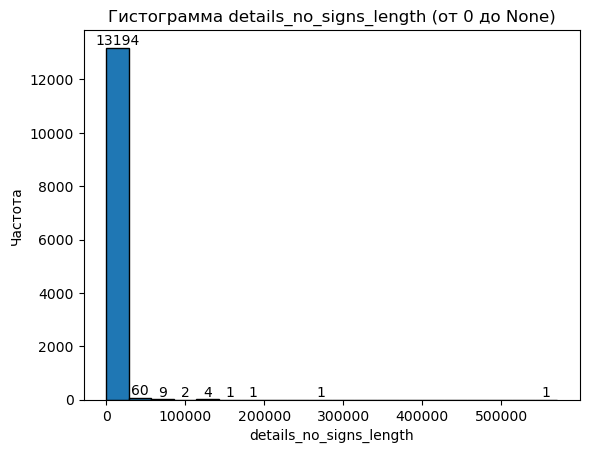

Показано значений: 13273 из 13273 (100.00%)
Ширина одного бина: 28538


In [29]:
plot_hist(df, "details_no_signs_length", bins=20, show_bin_counts=True)

#### Удаляем адреса email, встречающиеся за пределами подписей
 
Опять-таки, делаем это для того, чтобы модель не пыталась делать похожими запросы по повторяющимся адресам.

Адреса встречаются двух видов:

- традиционные интернет-адреса: "Иван Иванов" <i.ivanov@ya.ru>
- иерархические адреса в формате Lotus Notes: Иван Иванов/depart/org

А еще они бывают написаны кириллицей или латиницей с использованием диакритических знаков. Поэтому используем regex и расширенный синтаксис p{L} (буквы Unicode).

In [30]:
import regex

EMAIL_STD = r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}"
EMAIL_NOTES = r"(?:\p{L}+[ \t\r\n]*){1,2}(?:/[\p{L}0-9._-]+){1,}" 

# 1. имя + email в скобках
PATTERN_EMAIL_WITH_NAME = regex.compile(
    rf"""
    ["']?
    (?:\p{{L}}+[ \t\r\n]*){{1,2}}   # если без кавычек, то до 2 слов максимум
    ["']?
    \s*
    [<\(\[]
    \s*
    {EMAIL_STD}
    \s*
    [>\)\]]
    """,
    regex.VERBOSE | regex.UNICODE
)

# 2. простой email
PATTERN_EMAIL_ONLY = regex.compile(EMAIL_STD, regex.UNICODE)

# 3. Notes email
PATTERN_NOTES = regex.compile(EMAIL_NOTES, regex.UNICODE)

def remove_emails(text: str) -> str:
    text = PATTERN_EMAIL_WITH_NAME.sub("", text)
    text = PATTERN_EMAIL_ONLY.sub("", text)
    text = PATTERN_NOTES.sub("", text)
    return text, len(text)

In [31]:
s = """
Это тест 
from: dominoadministrator/отдел ё/организация to: vladimir.xxx@mmm.eee.com, it@nnn.eee.com date: 07.04.2020 16:48 subject: new connect
Иван Иванов <i.ivanov@ya.ru> Иван Иванов/depart/org фывафывафывафыва as;ldfkjasdlfkajsdf;la ksdjf
Best Regards/С уважением/Ar cieņu
"""

In [32]:
remove_emails(s)

('\nЭто тест \nfrom:   to: ,  date: 07.04.2020 16:48 subject: new connect\n  фывафывафывафыва as;ldfkjasdlfkajsdf;la ksdjf\n  cieņu\n',
 126)

In [33]:
df[["details_no_signs_emails", "details_no_signs_emails_length"]] = (
    df["details_no_signs"]
    .progress_map(remove_emails)
    .apply(pd.Series)   # раскладываем кортеж в две колонки
)

100%|██████████| 13273/13273 [00:28<00:00, 471.15it/s]


In [34]:
# Проверим, остались ли адреса
RE_STD = regex.compile(EMAIL_STD, regex.UNICODE)
RE_NOTES = regex.compile(EMAIL_NOTES, regex.UNICODE)

def find_email_snippets(text: str, context: int = 40):
    """
    Находит email/Notes-адреса в тексте и возвращает список фрагментов вокруг них.
    """
    if not isinstance(text, str):
        return []

    snippets = []
    for pat in (RE_STD, RE_NOTES):
        for m in pat.finditer(text):
            start = max(0, m.start() - context)
            end = min(len(text), m.end() + context)
            snippet = text[start:m.start()] + "[" + m.group() + "]" + text[m.end():end]
            snippets.append(snippet.strip())
    return snippets


all_snippets = []

for _, row in df.iterrows():
    snippets = find_email_snippets(row["details_no_signs_emails"])
    for snip in snippets:
        all_snippets.append((row["details_filename"], snip))

if all_snippets:
    print(f"⚠️ Найдено всего {len(all_snippets)} адресов\n")
    for fn, snip in all_snippets:
        print(f"Файл: {fn}")
        print(f"\n---------------------------------\n{snip}\n-------------------------------\n")
else:
    print("✅ Всё чисто")

⚠️ Найдено всего 9 адресов

Файл: CY-5054.txt

---------------------------------
eriet direktoriju, kur atrodas restapi. [lūdzu palaidiet  /a-] > files.txt un atsūtiet mums failu file
-------------------------------

Файл: CY-4445.txt

---------------------------------
в клиенте пользователя как вы написали. [устарел  /ru] если делать ресертификацию пользователя
-------------------------------

Файл: CY-744.txt

---------------------------------
(excell failā) gribēju iekopēt stropā. [ieejot  /likvidācijas] komitejas protokoli 2019 es neredzu vis
-------------------------------

Файл: CY-677.txt

---------------------------------
авить удаление по шаблону, например cd %[i  /q] тогда общий " "tokens=2 delims==" %i in
-------------------------------

Файл: CY-677.txt

---------------------------------
etype=3 or drivetype=4" :value') do cd %[i  /q]" p.s. drivetype 3=local disk, drivetype
-------------------------------

Файл: CY-515.txt

---------------------------------
авить удаление п

Все найденные фрагменты - обычный текст, который регулярное выражение приняло за иерархический адрес Notes из-за слешей "/". Закончим на этом извлечение адресов.

### 2.3 Выделяем запросы из истории переписки

Так как от нас требуется вести поиск именно похожих запросов, было бы здорово отделить их от остального текста.

Как показало изучение файлов, история переписки в них содержится в обратном хронологическом порядке.

То есть собственно обращение в поддержку - в самом конце, над ним первый ответ, и так далее. Просто обрезать "хвост" не получится.

Но хорошо, что сообщения в файле разделены строками вида "ФИО - DD.MM.YYYY", где вместо ФИО - инициалы автора латиницей, а DD.MM.YYYY - дата отправки сообщения.

Разобьем историю переписки на сообщения по этим маркерам и самое последнее сообщение и будем считать собственно запросом.

#### Отделяем запросы от остальной переписки

In [35]:
import re

def extract_request(text):
    if not isinstance(text, str) or not text.strip():
        return 0, "", 0, "", "", "", 0

    # Паттерн для ABC - DD.MM.YYYY или ABC.DD.MM.YYYY
    pattern = r'([A-Za-z]{2,3})(?:\s-\s|\.)(\d{2}\.\d{2}\.\d{4})'
    matches = list(re.finditer(pattern, text))

    num_parts = len(matches)

    # Если заголовков нет - весь текст считаем запросом
    if num_parts == 0:
        ret_text = text.strip()
        return 1, ret_text, len(ret_text), "", "", "", 0

    # Извлекаем данные ПОСЛЕДНЕГО заголовка (самый старый = исходный запрос)
    last_match = matches[-1]
    initials, date = last_match.groups()

    # Извлекаем текст ПОСЛЕДНЕГО сообщения (исходный запрос)
    start = last_match.start()
    end = len(text)  # до конца текста
    request_text = text[start:end]
    request_text = re.sub(pattern, "", request_text, count=1).strip()
    request_length = len(request_text)

    # Разбиваем переписку на отдельные сообщения (всё ДО последнего заголовка)
    if num_parts > 1:
        conversation_parts = []
        for i in range(len(matches) - 1):  # все кроме последнего
            part_start = matches[i].start()
            part_end = matches[i + 1].start()
            part_text = text[part_start:part_end].strip()
            conversation_parts.append(part_text)

        # Разворачиваем порядок (от старого к новому)
        conversation_parts.reverse()
        conversation = "\n\n".join(conversation_parts)
    else:
        conversation = ""

    conversation_length = len(conversation)

    return num_parts, request_text, request_length, initials, date, conversation, conversation_length

In [36]:
df[["num_parts", "request", "request_length", "request_initials", "request_date", "conversation", "conversation_length"]] = df["details_no_signs_emails"].progress_apply(
    lambda x: pd.Series(extract_request(x)))

100%|██████████| 13273/13273 [00:01<00:00, 11801.30it/s]


#### Разбираемся с длинными запросами

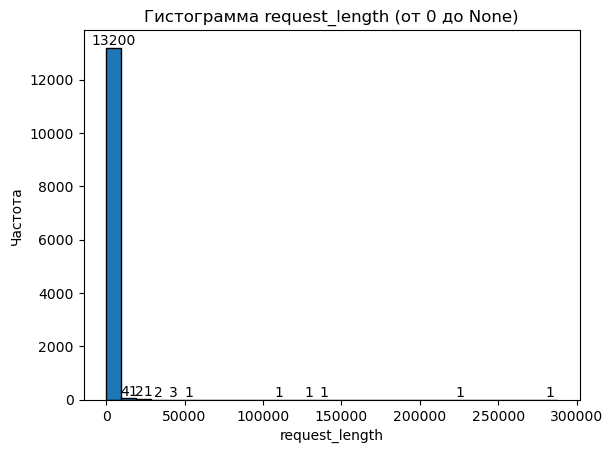

Показано значений: 13273 из 13273 (100.00%)
Ширина одного бина: 9585


In [37]:
plot_hist(df, "request_length", bins=30, show_bin_counts=True)

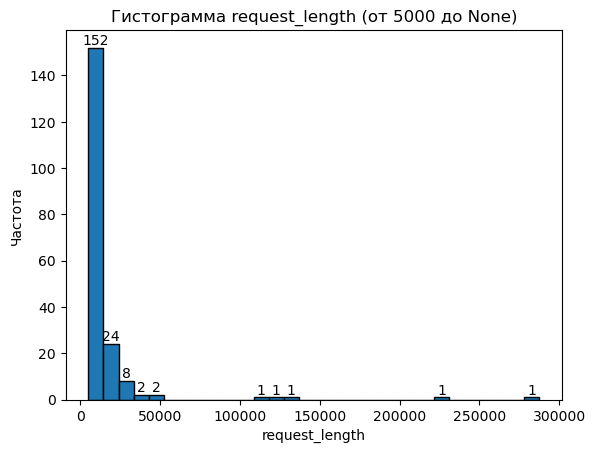

Отсечено слева (< 5000): 13080
Показано значений: 193 из 13273 (1.45%)
Ширина одного бина: 9418


In [38]:
plot_hist(df, "request_length", bins=30, show_bin_counts=True, low=5000)

Как показал анализ длинных запросов из "хвоста", суть запроса в них содержится в начале, а далее обычно идет длинный лог. Для экономии ресурсов обрежем все длинные запросы, длина которых больше 5000.

In [39]:
df["request_full"] = df["request"] # сохраняем на всякий случай
df["request_full_lentgth"] = df["request_length"]
df["request"] = df["request"].str[:5000]
df["request_length"] = df["request"].str.len()

## 3. Определим языки

Это позволит понять, распознает ли модель похожие по смыслу запросы на разных языках.

Используем библиотеку fasttext и модель lid.176.bin, которая понимает русский, английский и латышский.

Документация: https://fasttext.cc/docs/en/language-identification.html

A. Joulin, E. Grave, P. Bojanowski, T. Mikolov, Bag of Tricks for Efficient Text Classification

A. Joulin, E. Grave, P. Bojanowski, M. Douze, H. Jégou, T. Mikolov, FastText.zip: Compressing text classification models

Пример: https://amitness.com/posts/language-identification-python


In [40]:
import fasttext

In [41]:
#!wget -q https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

In [42]:
model_lid = fasttext.load_model("../models/fasttext/lid.176.bin")

In [43]:
def detect_lang_ft(model, text):
    """
    Возвращает наиболее вероятный язык и вероятность 
    """
    text = text.strip().replace("\n", " ")
    
    if not text:
        return None, None
    
    label, prob = model.predict(text, k=1)
    lang = label[0].replace("__label__", "")
    probability = prob[0]
    
    return lang, round(probability, 3)


In [45]:
detect_lang_ft(model_lid, sample(df, "CY-6600", "request", prt=False)) # для проверки - запрос на русском

('ru', 0.998)

In [46]:
detect_lang_ft(model_lid, sample(df, "CY-6569", "request", prt=False)) # для проверки - запрос на латышском

('lv', 0.401)

In [47]:
detect_lang_ft(model_lid, sample(df, "CY-6791", "request", prt=False)) # для проверки - запрос на английском

('en', 0.931)

Определим языки и вероятности их определения у всех запросов

In [49]:
df = df.copy()
df[["language", "lang_prob"]] = pd.DataFrame(
    df["request"].apply(lambda s: detect_lang_ft(model_lid, str(s)) or (None, None)).tolist(),
    index=df.index
)

Посмотрим, что получилось: выведем итоги по языкам и средние вероятности их определения

In [50]:
df.groupby("language").agg(
    count=("language", "size"),
    avg_prob=("lang_prob", "mean")
).sort_values("count", ascending=False)

,count,avg_prob
language,,
ru,5623,0.927360
lv,4215,0.842232
en,2959,0.647669
sl,32,0.186156
lt,31,0.345032
pl,29,0.284414
sr,16,0.273625
pt,12,0.336167
de,12,0.520583


Как показал анализ запросов, у которых язык был определен не как ru-en-lv, это 
- запросы, выполненные по-русски транслитерацией
- запросы с неубранными дисклеймерами на немецком, финском и др.

Запросов, действительно выполненных на этих языках, в датасете не обнаружено. 

Что с ними делать в продакшене - решим потом. По идее, должна помочь дополнительная чистка подписей и дисклеймеров. А пока для чистоты эксперимента удаляем.

In [51]:
df = df[df["language"].isin(["ru", "en", "lv"])]
df["language"].value_counts()

language
ru    5623
lv    4215
en    2959
Name: count, dtype: int64

In [52]:
df.shape

(12797, 22)

На этом подвиге мы покончили с предварительной очисткой датасета. Сохраняем его, а работу с моделями продолжим в других ноутбуках.

In [53]:
df = df.drop(columns=["phones"]) # streamlit, используемый в приложении разметки, не переваривает колонок со сложной структурой

In [54]:
df.to_parquet("../data/requests.parquet", index=False)